In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import warnings

In [2]:
import sys
sys.path.insert(0, '../')

from dynamical_model import DynamicalModel

In [3]:
## default values to test with
r_eff = 1.85
theta_e = 1.63
gamma = 1.95

## test single aperture calculation

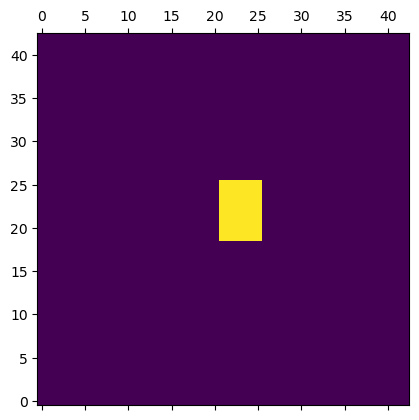

In [4]:
binning = np.zeros((43, 43))

binning[22-3:22+4, 23-2:23+3] = np.ones((7, 5))

plt.matshow(binning, origin='lower')

### test single aperture vs Voronoi binning in `Galkin`

In [5]:
anisotropy_model = 'constant'
ani_param = 1.1

dyn_model = DynamicalModel(mass_model='powerlaw')

for i in range(1):
    # binned
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    
    np.random.seed(i)
    
    a = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                       [theta_e, gamma, 1],
                                       ani_param=ani_param,
                                       anisotropy_model=anisotropy_model,
                                       supersampling_factor=5, 
                                       aperture_type='ifu',
                                       voronoi_bins=binning-1 #binning-1
                                      )
    
    # single-slit
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=True
    )
    
    np.random.seed(i)
    b = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                       [theta_e, gamma, 1],
                                       ani_param=ani_param,
                                       anisotropy_model=anisotropy_model,
                                       supersampling_factor=5, 
                                       aperture_type='single_slit',
                                       voronoi_bins=binning-1 #binning-1
                                      )
    
    print(a[0][0], b[0])
    
    if np.abs(a[0][0] - b[0])/a[0][0] > 0.3/100:
        warnings.warn('Voronoi binning in galkin only fails! 🙁')
    else:
        print('Models match within 0.3%. 🙂')

295.35304251581186 295.1877220114605
Models match within 0.3%. 🙂


### test single-aperture-like Voronoi bins in galkin vs jampy

In [6]:
anisotropy_model = 'constant'
ani_param = 0.9

dyn_model = DynamicalModel(mass_model='powerlaw')

for i in range(1):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    
    a = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                           [theta_e, gamma, 1],
                                           ani_param=ani_param,
                                           anisotropy_model=anisotropy_model,
                                           supersampling_factor=5, 
                                           aperture_type='ifu',
                                           voronoi_bins=binning-1 #binning-1
                                           )
    
    
    np.random.seed(i)
    b = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 1],
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=True,
                                            voronoi_bins=binning-1
                                           )
    
    print(a[0][0], b[0][0])
    
    if np.abs(a[0][0] - b[0][0])/a[0][0] > 1./100:
        warnings.warn('Voronoi binning between galkin and jampy doesn\'t agree! 🙁')
        print('{:.2f}% difference'.format(np.abs(a[0][0] - b[0][0])/a[0][0]*100))
    else:
        print('Models match within 1%. 🙂')

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
316.9371866374893 312.4083287022799
1.43% difference


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_59878/3975797218.py:35: UserWarning: Voronoi binning between galkin and jampy doesn't agree! 🙁
  warnings.warn('Voronoi binning between galkin and jampy doesn\'t agree! 🙁')


## IFU test

### constant

(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


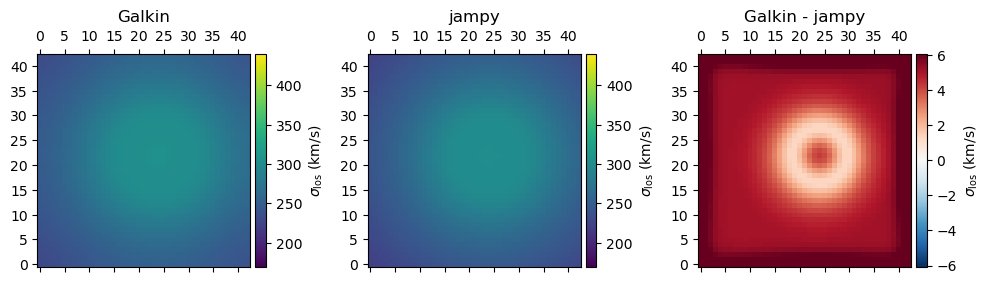

In [7]:
dyn_model.PSF_FWHM = 0.7
anisotropy_model = 'constant'
ani_param = 1. # isotropic

dyn_model = DynamicalModel(mass_model='powerlaw')
    
for i in range(10):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    a, _ = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                           [theta_e, gamma, 1],
                                           ani_param=ani_param,
                                           anisotropy_model=anisotropy_model,
                                           supersampling_factor=5, 
                                           aperture_type='ifu',
                                           voronoi_bins=None #binning-1
                                           )
    print(a.shape)
    
    np.random.seed(i)
    b, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 1],
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=True,
                                            voronoi_bins=None
                                           )
    print(b.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    
    def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
        divider = make_axes_locatable(axes[i])
        im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')
        
    #cbar = axes[0].matshow(a[0], origin='lower')
    #cbar = axes[1].matshow(b[0], origin='lower')
    #plt.colorbar(cbar)

    #cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
    #plt.colorbar(cbar)
    plot_mat(a.reshape((43, 43)), 0, cmap='viridis')
    plot_mat(b.reshape((43, 43)), 1, cmap='viridis')
    plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
             vmax=np.max(b)*0.02, vmin=-np.max(b)*0.02)
    
    axes[0].set_title('Galkin')
    axes[1].set_title('jampy')
    axes[2].set_title('Galkin - jampy')
    
    fig.tight_layout()
    break

### Osipkov-Merritt

(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


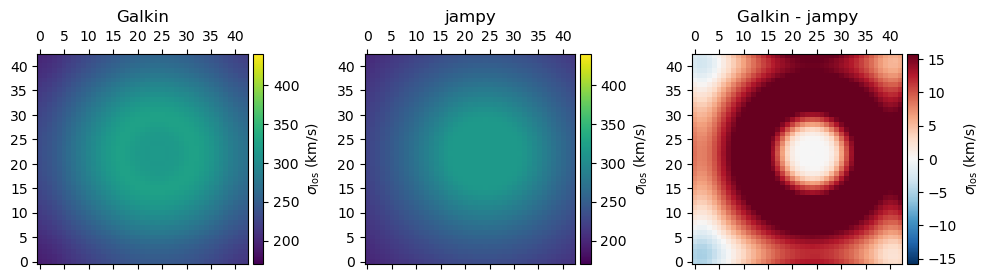

In [8]:
anisotropy_model = 'Osipkov-Merritt'
ani_param = 2

dyn_model.PSF_FWHM = 0.7

for i in range(10):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    dyn_model = DynamicalModel(mass_model='powerlaw')
    a, _ = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                           [theta_e, gamma, 1], 
                                           ani_param=ani_param,
                                           anisotropy_model=anisotropy_model,
                                           supersampling_factor=5, 
                                           aperture_type='ifu',
                                           voronoi_bins=None, #binning-1
                                           )
    print(a.shape)
    
    np.random.seed(i)
    b, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 1],
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=True,
                                            voronoi_bins=None
                                           )
    print(b.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    
    def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
        divider = make_axes_locatable(axes[i])
        im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')
        
    #cbar = axes[0].matshow(a[0], origin='lower')
    #cbar = axes[1].matshow(b[0], origin='lower')
    #plt.colorbar(cbar)

    #cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
    #plt.colorbar(cbar)
    plot_mat(a.reshape((43, 43)), 0, cmap='viridis')
    plot_mat(b.reshape((43, 43)), 1, cmap='viridis')
    plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=np.max(b)*0.05, vmin=-np.max(b)*0.05)
    
    axes[0].set_title('Galkin')
    axes[1].set_title('jampy')
    axes[2].set_title('Galkin - jampy')
    
    fig.tight_layout()
    break

## Check between oblate and prolate

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
oblate
(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
[1.16224988 1.16224988 1.16224988 1.16224988 1.16224988 1.16224988
 1.16224988 1.16224988 1.16224988 1.16224988 1.16224988 1.16224988
 1.16224988 1.16224988 1.16224988 1.16224988 1.16224988 1.16224988
 1.16224988 1.16224988]
prolate
(43, 43)


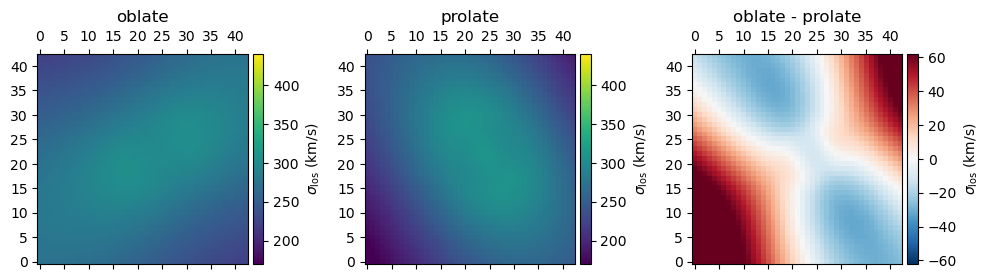

In [12]:
dyn_model.PSF_FWHM = 0.7
anisotropy_model = 'constant'
ani_param = 1. # isotropic

dyn_model = DynamicalModel(mass_model='powerlaw')
    
for i in range(10):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    a, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 1],
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=False,
                                            voronoi_bins=None, shape='oblate',
                                           )
    print(a.shape)
    
    np.random.seed(i)
    b, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 1],
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=False,
                                            voronoi_bins=None, shape='prolate',
                                           )
    print(b.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    
    def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
        divider = make_axes_locatable(axes[i])
        im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')
        
    #cbar = axes[0].matshow(a[0], origin='lower')
    #cbar = axes[1].matshow(b[0], origin='lower')
    #plt.colorbar(cbar)

    #cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
    #plt.colorbar(cbar)
    plot_mat(a.reshape((43, 43)), 0, cmap='viridis')
    plot_mat(b.reshape((43, 43)), 1, cmap='viridis')
    plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
             vmax=np.max(b)*0.2, vmin=-np.max(b)*0.2)
    
    axes[0].set_title('oblate')
    axes[1].set_title('prolate')
    axes[2].set_title('oblate - prolate')
    
    fig.tight_layout()
    break

### check difference between n_gauss settings

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


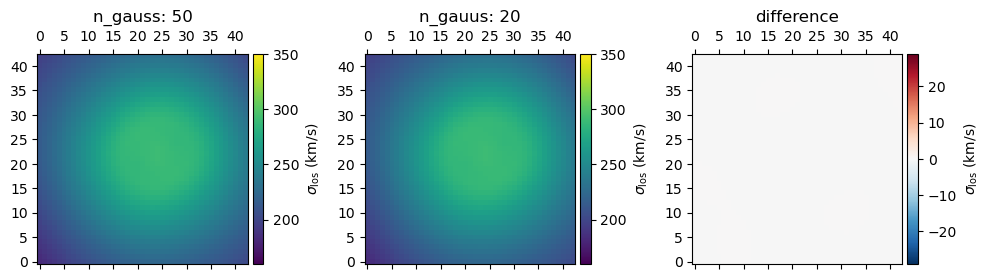

In [9]:
anisotropy_model = 'constant'
ani_param = 1

n_gauss_1 = 50
n_gauss_2 = 20

dyn_model = DynamicalModel(mass_model='powerlaw', n_gauss=n_gauss_1)
np.random.seed(2)
a, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 0.6],
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None
                                       )
print(a.shape)

dyn_model_2 = DynamicalModel(mass_model='powerlaw', n_gauss=n_gauss_2)
np.random.seed(2)
b, _ = dyn_model_2.compute_jampy_v_rms_model([theta_e, gamma, 0.6], 
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None
                                       )

print(b.shape)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
#axes = [axes]

def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
    divider = make_axes_locatable(axes[i])
    im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')

#cbar = axes[0].matshow(a[0], origin='lower')
#cbar = axes[1].matshow(b[0], origin='lower')
#plt.colorbar(cbar)

#cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
#plt.colorbar(cbar)
plot_mat(a.reshape((43, 43)), 0, cmap='viridis', vmax=350, vmin=160)
plot_mat(b.reshape((43, 43)), 1, cmap='viridis', vmax=350, vmin=160)
plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=np.max(b)*0.1, vmin=-np.max(b)*0.1)

axes[0].set_title('n_gauss: {}'.format(n_gauss_1))
axes[1].set_title('n_gauus: {}'.format(n_gauss_2))
axes[2].set_title('difference')

fig.tight_layout()

## check between MGE range

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


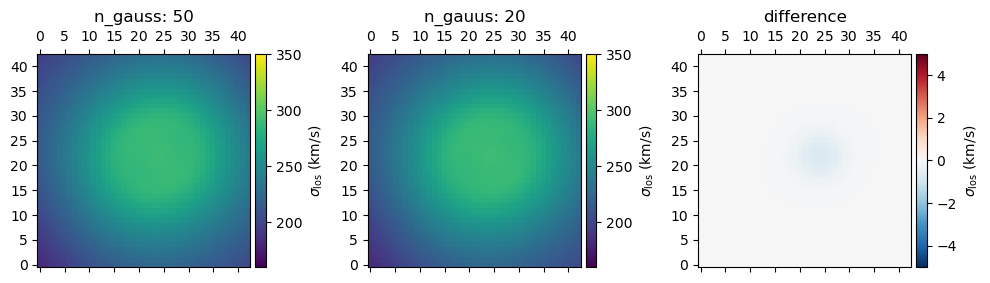

In [10]:
anisotropy_model = 'constant'
ani_param = 1

n_gauss_1 = 50
n_gauss_2 = 20

dyn_model = DynamicalModel(mass_model='powerlaw', n_gauss=n_gauss_1,
                           mass_profile_min=10**-2.5, mass_profile_max=10**2.
                          )
np.random.seed(2)
a, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 0.6],
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None
                                       )
print(a.shape)

dyn_model_2 = DynamicalModel(mass_model='powerlaw', n_gauss=n_gauss_1,
                           mass_profile_min=10**-4.5, mass_profile_max=10**3
                          )
np.random.seed(2)
b, _ = dyn_model_2.compute_jampy_v_rms_model([theta_e, gamma, 0.6], 
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None
                                       )

print(b.shape)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
#axes = [axes]

def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
    divider = make_axes_locatable(axes[i])
    im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')

#cbar = axes[0].matshow(a[0], origin='lower')
#cbar = axes[1].matshow(b[0], origin='lower')
#plt.colorbar(cbar)

#cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
#plt.colorbar(cbar)
plot_mat(a.reshape((43, 43)), 0, cmap='viridis', vmax=350, vmin=160)
plot_mat(b.reshape((43, 43)), 1, cmap='viridis', vmax=350, vmin=160)
plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=5, vmin=-5)

axes[0].set_title('n_gauss: {}'.format(n_gauss_1))
axes[1].set_title('n_gauus: {}'.format(n_gauss_2))
axes[2].set_title('difference')

fig.tight_layout()

## elliptical vs spherical

### without PSF convolution in IFU

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


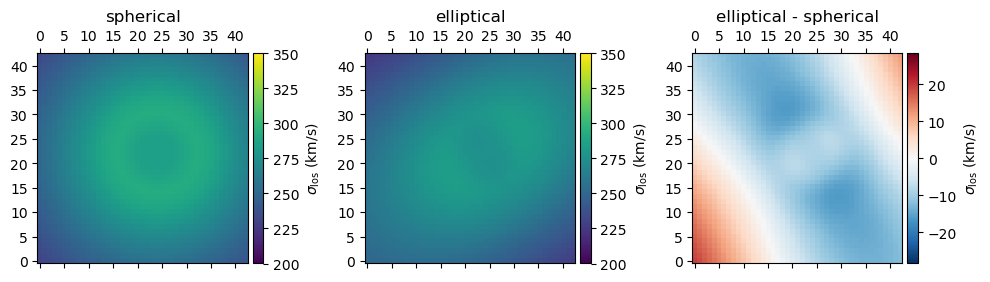

In [11]:
anisotropy_model = 'constant'
ani_param = 1


dyn_model = DynamicalModel(mass_model='powerlaw')

theta_e = 1.63317001e+00
gamma = 1.95886843e+00
q = 7.61476589e-01 
pa = 1.15742114e+02,
#1.87925701e+03, 9.06948652e+01, 8.71954746e-01, 
ani_param = 1.26886523e+00
    
dyn_model.PSF_FWHM = 0.7 

np.random.seed(2)
a, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, 1], pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None,
                                        is_spherical=True,
                                        do_convolve=True,
                                        q_light=1
                                       )
print(a.shape)

np.random.seed(2)
b, _ = dyn_model.compute_jampy_v_rms_model([theta_e, gamma, q], 
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None,
                                        do_convolve=True,
                                        q_light=None                                
                                       )

print(b.shape)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
#axes = [axes]

def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
    divider = make_axes_locatable(axes[i])
    im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')

#cbar = axes[0].matshow(a[0], origin='lower')
#cbar = axes[1].matshow(b[0], origin='lower')
#plt.colorbar(cbar)

#cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
#plt.colorbar(cbar)
plot_mat(a.reshape((43, 43)), 0, cmap='viridis', vmax=350, vmin=200)
plot_mat(b.reshape((43, 43)), 1, cmap='viridis', vmax=350, vmin=200)
plot_mat(b.reshape((43, 43)) - a.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=np.max(b)*0.1, vmin=-np.max(b)*0.1)

axes[0].set_title('spherical')
axes[1].set_title('elliptical')
axes[2].set_title('elliptical - spherical')

fig.tight_layout()

## power-law vs composite

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


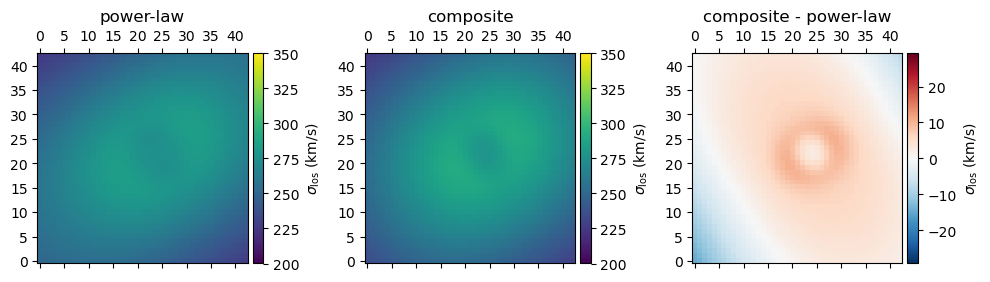

In [12]:
anisotropy_model = 'constant'
ani_param = 1


dyn_model = DynamicalModel(mass_model='powerlaw')

ani_param = 1.26886523e+00
    
dyn_model.PSF_FWHM = 0.7 

np.random.seed(2)
a, _ = dyn_model.compute_jampy_v_rms_model([1.63445014e+00, 1.95743119e+00, 7.61627596e-01],
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None,
                                        do_convolve=True,
                                        q_light=None     
                                       )
print(a.shape)

np.random.seed(2)
dyn_model = DynamicalModel(mass_model='composite')
b, _ = dyn_model.compute_jampy_v_rms_model([5.49489633e-02, 2.14856643e+01, 2.01093181e+00, 7.31653932e-01], 
                                        pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None,
                                        do_convolve=True,
                                        q_light=None                                
                                       )

print(b.shape)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
#axes = [axes]

def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
    divider = make_axes_locatable(axes[i])
    im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')

#cbar = axes[0].matshow(a[0], origin='lower')
#cbar = axes[1].matshow(b[0], origin='lower')
#plt.colorbar(cbar)

#cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
#plt.colorbar(cbar)
plot_mat(a.reshape((43, 43)), 0, cmap='viridis', vmax=350, vmin=200)
plot_mat(b.reshape((43, 43)), 1, cmap='viridis', vmax=350, vmin=200)
plot_mat(b.reshape((43, 43)) - a.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=np.max(b)*0.1, vmin=-np.max(b)*0.1)

axes[0].set_title('power-law')
axes[1].set_title('composite')
axes[2].set_title('composite - power-law')

fig.tight_layout()

## single slit spherical vs elliptical

In [13]:
anisotropy_model = 'constant'
ani_param = 1


dyn_model = DynamicalModel(mass_model='powerlaw')
dyn_model.psf_fwhm = 0.7

np.random.seed(2)
a, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                        gamma,
                                        q=1, pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None,
                                        is_spherical=True,
                                        aperture_type='single_slit',
                                        
                                       )
#print(a.shape)

np.random.seed(2)
b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                        gamma,
                                        q=0.75, pa=121,
                                        ani_param=ani_param,
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None,
                                        aperture_type='single_slit'
                                       )

#print(b.shape)

print('spherical: {:.2f} km/s, elliptical: {:.2f} km/s'.format(a, b))

TypeError: compute_jampy_v_rms_model() got an unexpected keyword argument 'q'

### ellipticity dependenc in mass and light

In [ ]:
N = 20
v_rms_array = []
q_array = np.linspace(1, 0.75, N) 

anisotropy_model = 'constant'
ani_param = 1.

dyn_model.psf_fwhm = 0.7

for q in q_array:
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=q, pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            voronoi_bins=None,
                                            do_convolve=True,   
                                            aperture_type='single_slit',
                                            q_light=1.
                                           )
    v_rms_array.append(b)
    
    
plt.plot(q_array, v_rms_array, label='q_mass changing, q_light = 1')


v_rms_array = []
q_array = np.linspace(1, 0.75, N) 

for q in q_array:
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=q, pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            voronoi_bins=None,
                                            do_convolve=True,
                                            aperture_type='single_slit',
                                            q_light=None
                                           )
    v_rms_array.append(b)
    
    
plt.plot(q_array, v_rms_array, label='q_mass changing, q_light=0.88')
plt.xlabel('q')
plt.ylabel('v_rms (km/s)')
plt.legend()

plt.show()


In [ ]:
N = 20
v_rms_array = []
q_array = np.linspace(1, 0.65, N) 

anisotropy_model = 'constant'
ani_param = 1.

dyn_model.psf_fwhm = 1e-3

for q in q_array:
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=1., pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            voronoi_bins=None,
                                            do_convolve=True,   
                                            aperture_type='single_slit',
                                            q_light=q
                                           )
    v_rms_array.append(b)
    
    
plt.plot(q_array, v_rms_array, label='q_light changing, q_mass =1')


v_rms_array = []

for q in q_array:
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=q, pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            voronoi_bins=None,
                                            do_convolve=True,
                                            aperture_type='single_slit',
                                            q_light=1.
                                           )
    v_rms_array.append(b)
    
    
plt.plot(q_array, v_rms_array, label='q_mass changing, q_light=1')
plt.xlabel('q')
plt.ylabel('v_rms (km/s)')
plt.legend()


v_rms_array = []

for q in q_array:
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=q, pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            voronoi_bins=None,
                                            do_convolve=True,
                                            aperture_type='single_slit',
                                            q_light=q
                                           )
    v_rms_array.append(b)
    
    
plt.plot(q_array, v_rms_array, label='both q chaning together')
plt.xlabel('q')
plt.ylabel('v_rms (km/s)')
plt.legend()
plt.show()


### radial binning

In [ ]:
radial_bin_map = np.zeros((43, 43)) * np.nan

n_bins = 11
r_bins = np.linspace(0.0, 0.94, n_bins+1) / 0.1457 * 2
r_bins = np.array([0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.5, 0.6, 0.75, 0.94]) / 0.1457 * 2
n_bins = len(r_bins) - 1
x_center, y_center = 22, 24

print('bin boundaries', r_bins)

for i in range(radial_bin_map.shape[0]):
    for j in range(radial_bin_map.shape[1]):
        r = np.sqrt((i - x_center)**2 + (j - y_center)**2)        
#         if 0. <= r < r_bins[0]:
#             radial_bin_map[i, j] = 0
        for n in range(len(r_bins)-1):    
            if r_bins[n] <= r < r_bins[n+1]:
                radial_bin_map[i, j] = n

# radial_bin_map += 1
# radial_bin_map[x_center, y_center] = 0

# print(np.nanmax(radial_bin_map)+1, len(r_bins) - 1)

# print(radial_bin_map[x_center, y_center])

plt.matshow(radial_bin_map, origin='lower')
plt.title('Radial binning map');

In [ ]:
N = 20
v_rms_array = []
q_array = np.linspace(1, 0.75, N) 

anisotropy_model = 'constant'
ani_param = 0.1

dyn_model.psf_fwhm = 0.7

for beta in np.linspace(-0.2, 0.4, 7):
    ani_param = np.sqrt(1 - beta)
    a, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=1., pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            do_convolve=True,   
                                            aperture_type='ifu',
                                            is_spherical=True,
                                            q_light=1.,
                                            voronoi_bins=radial_bin_map
                                           )



    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            q=q, pa=121,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            do_convolve=True,
                                            aperture_type='ifu',
                                            q_light=None,
                                            voronoi_bins=radial_bin_map
                                           )


    rs = r_bins[:-1] * 0.1457 + (r_bins[1] - r_bins[0])
    plt.plot(rs, (b-a)/b, label=r'$\beta = {:.2f}$'.format(beta)) #, label='spherical')
    #plt.plot(rs, b, label='elliptical')
    
plt.axhline(y=0, ls='--', color='grey')
plt.title('relative difference of elliptical - spherical')
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel('fractional difference')
plt.legend()
plt.show()